In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import os
from scipy.io import loadmat
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from scipy.stats.stats import pearsonr 
from scipy.stats import spearmanr
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab  import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = '/content/gdrive/My Drive/QoE_LSTM_model'

In [0]:
train_val_set = loadmat(path + '/training_videos_set.mat')

In [6]:
train_val_set.keys()

dict_keys(['__header__', '__version__', '__globals__', 'training_videos_set', 'validation_videos_set'])

In [7]:
train_val_set['training_videos_set'][:10]

array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 16, 18, 19, 20, 22,
        23, 26, 28, 30, 31, 32, 33, 34, 36],
       [ 1,  4,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        23, 24, 27, 28, 29, 32, 33, 34, 36],
       [ 1,  4,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22,
        23, 24, 26, 28, 29, 32, 34, 35, 36],
       [ 1,  2,  3,  7,  8,  9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 25, 26, 27, 30, 31, 33, 35],
       [ 1,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 26, 27, 28, 33, 34, 35],
       [ 1,  3,  5,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21,
        23, 25, 27, 29, 30, 31, 32, 33, 36],
       [ 1,  2,  4,  5,  6,  8, 10, 11, 12, 15, 16, 17, 18, 22, 24, 25,
        26, 28, 29, 30, 31, 32, 34, 35, 36],
       [ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 20, 21, 22,
        23, 24, 25, 27, 29, 30, 34, 35, 36],
       [ 1,  3,  4,  5,  8, 10, 11, 12, 14, 15, 16, 17, 18, 20, 

In [0]:
training_videos_indices = train_val_set['training_videos_set']
validation_videos_indices = train_val_set['validation_videos_set']

In [0]:
num_of_training = training_videos_indices[0].shape[0]
num_of_validation = validation_videos_indices[0].shape[0]
num_of_videos = 36

In [0]:
timesteps = 4
num_of_layers = 2
num_of_units = 22
num_epochs = 100
batch_size = 1
num_of_features = 3
loss = 'mse'
opt = 'adam'

In [0]:
def train_val_processing(video_lst, index, attributes, target):
  num = video_lst[index]
  video = loadmat(path + '/QoE_matfiles' + '/video_' + str(num) + '.mat')


  NIQE = np.array(video['NIQE_ext'])
  number_rebuff = np.array(video['Nrebuffers'])
  time_elapsed = np.array(video['TSL'])
  scores = np.array(video['score_continuous'])

  #Scaling data:
  data_for_scaling = np.dstack((NIQE, scores))
  data_for_scaling = data_for_scaling.reshape(data_for_scaling.shape[1], data_for_scaling.shape[2])

  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data_for_scaling)
  scaled_data = scaler.transform(data_for_scaling)

  NIQE_norm = scaled_data[:,0]
  scores_norm = scaled_data[:,1]
  scores_norm = scores_norm.reshape(scores_norm.shape[0], 1)

  video_features = np.dstack((NIQE_norm, number_rebuff, time_elapsed))
  video_features = video_features.reshape(video_features.shape[1], video_features.shape[2])

  if index == 0:
    attributes = video_features
    target = scores_norm
  else:
    attributes = np.vstack((attributes, video_features))
    target = np.vstack((target, scores_norm))

  return attributes, target

  


In [0]:
def init_LSTM_model(num_of_layers, num_of_units, batch_size, timesteps, num_features, loss, optimizer):
  model = Sequential()

  layer = 1
  model.add(LSTM(num_of_units, batch_input_shape=(batch_size, timesteps, num_features), return_sequences= True, stateful = True))
  while layer < num_of_layers:
    model.add(LSTM(num_of_units, return_sequences= True, stateful = True))
    layer += 1

  model.add(TimeDistributed(Dense(1, activation = 'relu')))
  model.compile(loss = loss, optimizer = optimizer)

  return model
  

In [0]:
def train_LSTM_model(X, y, X_validation, y_validation, num_of_epochs, num_of_layers, num_of_units, batch_size, timesteps, num_features, loss, optimization):
  model = init_LSTM_model(num_of_layers, num_of_units, batch_size, timesteps, num_features, loss, optimization)

  epoch = 1
  best_validation = float('inf')
  best_epoch = 1

  while epoch <= num_of_epochs:
    print('*'*15)
    print('Current epoch number: ', epoch)
    history = model.fit(X, y, nb_epoch = 1, 
                        batch_size = batch_size,
                        verbose = 2,
                        shuffle = False,
                        validation_data = (X_validation, y_validation))
    curr_valid_loss = history.history['val_loss'][0]
    
    if epoch >= 5:
      if curr_valid_loss < best_validation:
        best_validation = curr_valid_loss
        best_epoch = epoch
        print('Best epoch number: ', best_epoch)
        print('Best validation loss: ', best_validation)
        model.save_weights(filepath=path + '/best_model_weights.hdf5',overwrite=True)

    print('*'*15)	    	   
    epoch += 1

  net = init_LSTM_model(num_of_layers,num_of_units,batch_size,1,num_of_features,loss,optimization)    
  net.load_weights(path + '/best_model_weights.hdf5')
  os.remove( path + '/best_model_weights.hdf5')
  return net

    


In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_LSTM_model_2(X, y, X_validation, y_validation, num_of_epochs, num_of_layers, num_of_units, batch_size, timesteps, num_features, loss, optimization, num_video):
  model = init_LSTM_model(num_of_layers, num_of_units, batch_size, timesteps, num_features, loss, optimization)
  callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10), ModelCheckpoint(path + '/model' + str(num_video) + '_checkpoint.h5', save_best_only = True)]  
  history = model.fit(X, y, nb_epoch = num_of_epochs, 
                      batch_size = batch_size,
                      verbose = 2,
                      shuffle = False,
                      validation_data = (X_validation, y_validation),
                      callbacks = callbacks)

Test video number:  1
***************
Current epoch number:  1
Train on 895 samples, validate on 895 samples
Epoch 1/1
 - 5s - loss: 0.0590 - val_loss: 0.0380
***************
***************
Current epoch number:  2
Train on 895 samples, validate on 895 samples
Epoch 1/1
 - 5s - loss: 0.0263 - val_loss: 0.0221
***************
***************
Current epoch number:  3
Train on 895 samples, validate on 895 samples
Epoch 1/1
 - 5s - loss: 0.0230 - val_loss: 0.0195
***************
***************
Current epoch number:  4
Train on 895 samples, validate on 895 samples
Epoch 1/1
 - 5s - loss: 0.0218 - val_loss: 0.0188
***************
***************
Current epoch number:  5
Train on 895 samples, validate on 895 samples
Epoch 1/1
 - 5s - loss: 0.0211 - val_loss: 0.0184
Best epoch number:  5
Best validation loss:  0.018383187006314496
***************
***************
Current epoch number:  6
Train on 895 samples, validate on 895 samples
Epoch 1/1
 - 5s - loss: 0.0205 - val_loss: 0.0182
Best epoch

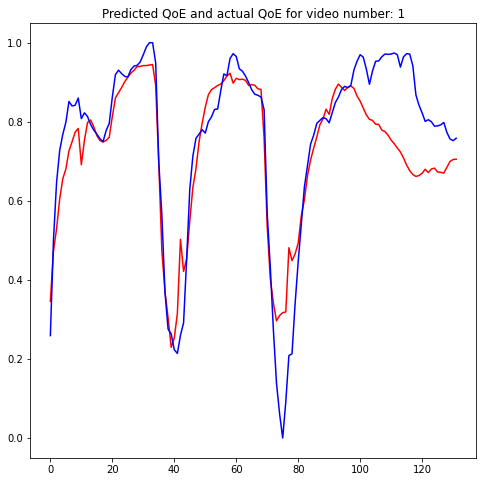

+++++++++++++++
Test video number:  2
***************
Current epoch number:  1
Train on 918 samples, validate on 918 samples
Epoch 1/1
 - 5s - loss: 0.0527 - val_loss: 0.0400
***************
***************
Current epoch number:  2
Train on 918 samples, validate on 918 samples
Epoch 1/1
 - 4s - loss: 0.0240 - val_loss: 0.0277
***************
***************
Current epoch number:  3
Train on 918 samples, validate on 918 samples
Epoch 1/1
 - 4s - loss: 0.0219 - val_loss: 0.0241
***************
***************
Current epoch number:  4
Train on 918 samples, validate on 918 samples
Epoch 1/1
 - 4s - loss: 0.0210 - val_loss: 0.0223
***************
***************
Current epoch number:  5
Train on 918 samples, validate on 918 samples
Epoch 1/1
 - 4s - loss: 0.0203 - val_loss: 0.0210
Best epoch number:  5
Best validation loss:  0.020993885827372043
***************
***************
Current epoch number:  6
Train on 918 samples, validate on 918 samples
Epoch 1/1
 - 4s - loss: 0.0198 - val_loss: 0

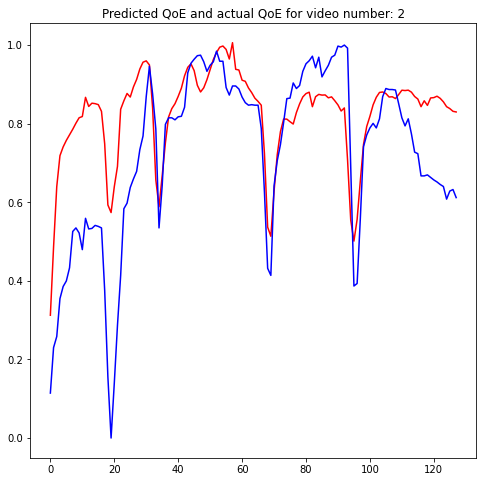

+++++++++++++++
Test video number:  3
***************
Current epoch number:  1
Train on 898 samples, validate on 898 samples
Epoch 1/1
 - 5s - loss: 0.0527 - val_loss: 0.0260
***************
***************
Current epoch number:  2
Train on 898 samples, validate on 898 samples
Epoch 1/1
 - 5s - loss: 0.0249 - val_loss: 0.0225
***************
***************
Current epoch number:  3
Train on 898 samples, validate on 898 samples
Epoch 1/1
 - 5s - loss: 0.0226 - val_loss: 0.0208
***************
***************
Current epoch number:  4
Train on 898 samples, validate on 898 samples
Epoch 1/1
 - 5s - loss: 0.0218 - val_loss: 0.0198
***************
***************
Current epoch number:  5
Train on 898 samples, validate on 898 samples
Epoch 1/1
 - 5s - loss: 0.0214 - val_loss: 0.0193
Best epoch number:  5
Best validation loss:  0.019273127387634127
***************
***************
Current epoch number:  6
Train on 898 samples, validate on 898 samples
Epoch 1/1
 - 5s - loss: 0.0211 - val_loss: 0

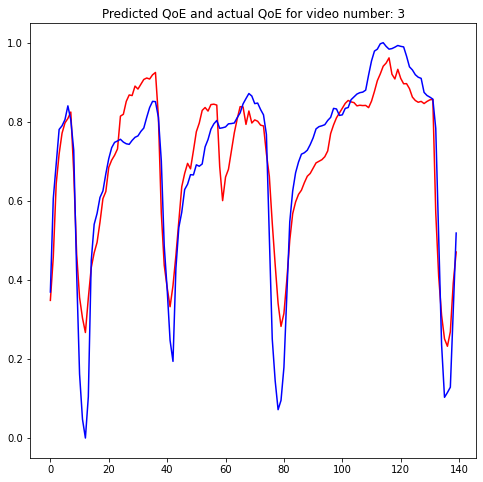

+++++++++++++++
Test video number:  4
***************
Current epoch number:  1
Train on 853 samples, validate on 853 samples
Epoch 1/1
 - 5s - loss: 0.2365 - val_loss: 0.0396
***************
***************
Current epoch number:  2
Train on 853 samples, validate on 853 samples
Epoch 1/1
 - 4s - loss: 0.0279 - val_loss: 0.0294
***************
***************
Current epoch number:  3
Train on 853 samples, validate on 853 samples
Epoch 1/1
 - 4s - loss: 0.0248 - val_loss: 0.0261
***************
***************
Current epoch number:  4
Train on 853 samples, validate on 853 samples
Epoch 1/1
 - 4s - loss: 0.0237 - val_loss: 0.0241
***************
***************
Current epoch number:  5
Train on 853 samples, validate on 853 samples
Epoch 1/1
 - 4s - loss: 0.0229 - val_loss: 0.0227
Best epoch number:  5
Best validation loss:  0.022672680337623798
***************
***************
Current epoch number:  6
Train on 853 samples, validate on 853 samples
Epoch 1/1
 - 4s - loss: 0.0221 - val_loss: 0

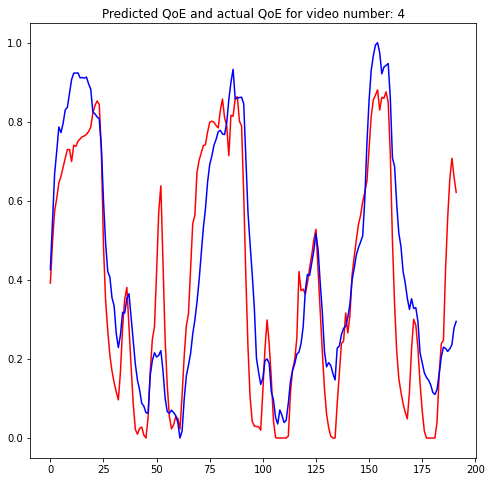

+++++++++++++++
Test video number:  5
***************
Current epoch number:  1
Train on 871 samples, validate on 871 samples
Epoch 1/1
 - 5s - loss: 0.0587 - val_loss: 0.0265
***************
***************
Current epoch number:  2
Train on 871 samples, validate on 871 samples
Epoch 1/1
 - 4s - loss: 0.0286 - val_loss: 0.0249
***************
***************
Current epoch number:  3
Train on 871 samples, validate on 871 samples
Epoch 1/1
 - 4s - loss: 0.0261 - val_loss: 0.0242
***************
***************
Current epoch number:  4
Train on 871 samples, validate on 871 samples
Epoch 1/1
 - 4s - loss: 0.0251 - val_loss: 0.0244
***************
***************
Current epoch number:  5
Train on 871 samples, validate on 871 samples
Epoch 1/1
 - 4s - loss: 0.0246 - val_loss: 0.0247
Best epoch number:  5
Best validation loss:  0.024709981101717706
***************
***************
Current epoch number:  6
Train on 871 samples, validate on 871 samples
Epoch 1/1
 - 4s - loss: 0.0242 - val_loss: 0

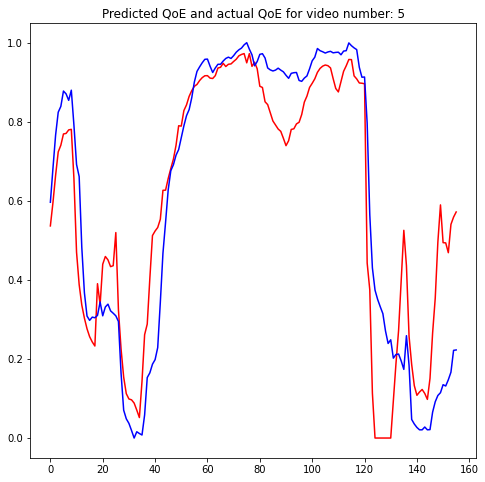

Streaming output truncated to the last 5000 lines.
Train on 880 samples, validate on 880 samples
Epoch 1/1
 - 5s - loss: 0.0160 - val_loss: 0.0142
Best epoch number:  56
Best validation loss:  0.01421881113900037
***************
***************
Current epoch number:  57
Train on 880 samples, validate on 880 samples
Epoch 1/1
 - 5s - loss: 0.0157 - val_loss: 0.0152
***************
***************
Current epoch number:  58
Train on 880 samples, validate on 880 samples
Epoch 1/1
 - 6s - loss: 0.0165 - val_loss: 0.0161
***************
***************
Current epoch number:  59
Train on 880 samples, validate on 880 samples
Epoch 1/1
 - 5s - loss: 0.0163 - val_loss: 0.0145
***************
***************
Current epoch number:  60
Train on 880 samples, validate on 880 samples
Epoch 1/1
 - 5s - loss: 0.0163 - val_loss: 0.0148
***************
***************
Current epoch number:  61
Train on 880 samples, validate on 880 samples
Epoch 1/1
 - 5s - loss: 0.0156 - val_loss: 0.0144
***************
*

In [21]:
LCC = []
SROCC = []
RMSE = []

for test_no in range(1, num_of_videos + 1):
  print('Test video number: ', test_no)
  attributes = []
  target = []
  attributes1 = []
  target1 = []
  test_attributes = []
  test_actual_scores = []

  training_videos_lst = training_videos_indices[test_no - 1]
  validation_videos_lst = validation_videos_indices[test_no - 1]

  #Training data preparation
  for train_idx in range(0,num_of_training):
      
      attributes, target = train_val_processing(training_videos_lst, train_idx, attributes, target)

  training_attrs = attributes[:int(len(attributes)//timesteps * timesteps),:]
  training_label = target[:int(len(target)//timesteps * timesteps), :]

  training_attrs_ts = training_attrs.reshape(-1, timesteps, training_attrs.shape[1])
  training_label_ts = training_label.reshape(-1, timesteps, training_label.shape[1])

  #Validation data preparation
  for val_idx in range(0,num_of_validation):

      attributes1, target1 = train_val_processing(validation_videos_lst, val_idx, attributes1, target1)

  validation_attrs = attributes1[:int(len(attributes1)//timesteps * timesteps),:]
  validation_label = target1[:int(len(target1)//timesteps * timesteps),:]

  validation_attrs_ts = training_attrs.reshape(-1, timesteps, validation_attrs.shape[1])
  validation_label_ts = training_label.reshape(-1, timesteps, validation_label.shape[1])

  #Testing data preparation
  test_video = loadmat(path + '/QoE_matfiles' + '/video_' + str(test_no) + '.mat')
  NIQE = np.array(test_video['NIQE_ext'])
  number_rebuff = np.array(test_video['Nrebuffers'])
  time_elapsed = np.array(test_video['TSL'])
  scores = np.array(test_video['score_continuous'])

  data_for_scaling = np.dstack((NIQE, scores))
  data_for_scaling = data_for_scaling.reshape(data_for_scaling.shape[1], data_for_scaling.shape[2])

  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data_for_scaling)
  scaled_data = scaler.transform(data_for_scaling)

  NIQE_norm = scaled_data[:,0]
  scores_norm = scaled_data[:,1]

  video_features = np.dstack((NIQE_norm, number_rebuff, time_elapsed))
  video_features = video_features.reshape(video_features.shape[1], video_features.shape[2])

  QoE_actual = scores_norm.reshape(scores_norm.shape[0], 1)
  test_attributes = video_features.reshape(-1, 1, video_features.shape[1])

  model = train_LSTM_model(training_attrs_ts, training_label_ts, validation_attrs_ts, validation_label_ts, num_epochs, num_of_layers, num_of_units, batch_size, timesteps, num_of_features, loss, opt)
  test_attributes = test_attributes[:int(len(test_attributes)//timesteps*timesteps),:]
  test_attributes = test_attributes.reshape(-1, 1, test_attributes.shape[2])
  pred = model.predict(test_attributes,batch_size=1)
  pred = np.reshape(pred, (-1,1))
  pred = pred.reshape(-1,pred.shape[0])[0]
  QoE_actual = QoE_actual[:int(len(QoE_actual)//timesteps*timesteps),:]
  QoE_actual = QoE_actual.reshape(-1,QoE_actual.shape[0])[0]
  
  LCC.append(pearsonr(pred, QoE_actual)[0])
  SROCC.append(spearmanr(pred, QoE_actual))
  RMSE.append(sqrt(mean_squared_error(pred, QoE_actual)))

  plt.figure(figsize=(8,8))
  plt.plot(pred, 'r', label = 'Predicted QoE')
  plt.plot(QoE_actual, 'b', label = 'Actual QoE')
  plt.title('Predicted QoE and actual QoE for video number: %d'%(test_no))
  plt.savefig(path + '/Pictures_1/fig_' + str(test_no) + '.png')
  if test_no <= 5:
    plt.show()
  else:
    plt.close()

  print('+' *15)

In [0]:
dead_model = []
for idx in range(0,len(LCC)):
  if math.isnan(LCC[idx]) == True:
    dead_model.append(idx + 1) 

In [25]:
LCC_ = []
SROCC_ = []
RMSE_ = []

for test_no in range(1, num_of_videos + 1):

  if test_no in dead_model:
    print('Test video number: ', test_no)
    attributes = []
    target = []
    attributes1 = []
    target1 = []
    test_attributes = []
    test_actual_scores = []

    training_videos_lst = training_videos_indices[test_no - 1]
    validation_videos_lst = validation_videos_indices[test_no - 1]

    #Training data preparation
    for train_idx in range(0,num_of_training):
        
        attributes, target = train_val_processing(training_videos_lst, train_idx, attributes, target)

    training_attrs = attributes[:int(len(attributes)//timesteps * timesteps),:]
    training_label = target[:int(len(target)//timesteps * timesteps), :]

    training_attrs_ts = training_attrs.reshape(-1, timesteps, training_attrs.shape[1])
    training_label_ts = training_label.reshape(-1, timesteps, training_label.shape[1])

    #Validation data preparation
    for val_idx in range(0,num_of_validation):

        attributes1, target1 = train_val_processing(validation_videos_lst, val_idx, attributes1, target1)

    validation_attrs = attributes1[:int(len(attributes1)//timesteps * timesteps),:]
    validation_label = target1[:int(len(target1)//timesteps * timesteps),:]

    validation_attrs_ts = training_attrs.reshape(-1, timesteps, validation_attrs.shape[1])
    validation_label_ts = training_label.reshape(-1, timesteps, validation_label.shape[1])

    #Testing data preparation
    test_video = loadmat(path + '/QoE_matfiles' + '/video_' + str(test_no) + '.mat')
    NIQE = np.array(test_video['NIQE_ext'])
    number_rebuff = np.array(test_video['Nrebuffers'])
    time_elapsed = np.array(test_video['TSL'])
    scores = np.array(test_video['score_continuous'])

    data_for_scaling = np.dstack((NIQE, scores))
    data_for_scaling = data_for_scaling.reshape(data_for_scaling.shape[1], data_for_scaling.shape[2])

    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(data_for_scaling)
    scaled_data = scaler.transform(data_for_scaling)

    NIQE_norm = scaled_data[:,0]
    scores_norm = scaled_data[:,1]

    video_features = np.dstack((NIQE_norm, number_rebuff, time_elapsed))
    video_features = video_features.reshape(video_features.shape[1], video_features.shape[2])

    QoE_actual = scores_norm.reshape(scores_norm.shape[0], 1)
    test_attributes = video_features.reshape(-1, 1, video_features.shape[1])

    model = train_LSTM_model(training_attrs_ts, training_label_ts, validation_attrs_ts, validation_label_ts, 100, num_of_layers, num_of_units, batch_size, timesteps, num_of_features, loss, opt)
    test_attributes = test_attributes[:int(len(test_attributes)//timesteps*timesteps),:]
    test_attributes = test_attributes.reshape(-1, 1, test_attributes.shape[2])
    pred = model.predict(test_attributes,batch_size=1)
    pred = np.reshape(pred, (-1,1))
    pred = pred.reshape(-1,pred.shape[0])[0]
    QoE_actual = QoE_actual[:int(len(QoE_actual)//timesteps*timesteps),:]
    QoE_actual = QoE_actual.reshape(-1,QoE_actual.shape[0])[0]
    
    LCC_.append(pearsonr(pred, QoE_actual)[0])
    SROCC_.append(spearmanr(pred, QoE_actual))
    RMSE_.append(sqrt(mean_squared_error(pred, QoE_actual)))

    plt.figure(figsize=(8,8))
    plt.plot(pred, 'r', label = 'Predicted QoE')
    plt.plot(QoE_actual, 'b', label = 'Actual QoE')
    plt.title('Predicted QoE and actual QoE for video number: %d'%(test_no))
    plt.savefig(path + '/Pictures_1/fig_' + str(test_no) + '.png')
    if test_no <= 5:
      plt.show()
    else:
      plt.close()

    print('+' *15)

Test video number:  15
***************
Current epoch number:  1
Train on 875 samples, validate on 875 samples
Epoch 1/1
 - 6s - loss: 0.0780 - val_loss: 0.0375
***************
***************
Current epoch number:  2
Train on 875 samples, validate on 875 samples
Epoch 1/1
 - 5s - loss: 0.0226 - val_loss: 0.0220
***************
***************
Current epoch number:  3
Train on 875 samples, validate on 875 samples
Epoch 1/1
 - 6s - loss: 0.0200 - val_loss: 0.0181
***************
***************
Current epoch number:  4
Train on 875 samples, validate on 875 samples
Epoch 1/1
 - 6s - loss: 0.0188 - val_loss: 0.0173
***************
***************
Current epoch number:  5
Train on 875 samples, validate on 875 samples
Epoch 1/1
 - 6s - loss: 0.0183 - val_loss: 0.0172
Best epoch number:  5
Best validation loss:  0.0171675757291918
***************
***************
Current epoch number:  6
Train on 875 samples, validate on 875 samples
Epoch 1/1
 - 7s - loss: 0.0177 - val_loss: 0.0172
***********

In [26]:
LCC

[0.9007063907423762,
 0.709760134818781,
 0.9252112936351106,
 0.8624629949256283,
 0.9054607610327586,
 0.6607631930007241,
 0.9603402512046377,
 0.6344139773190933,
 0.5929629708913213,
 0.8702893419964505,
 0.7934504043150932,
 0.9207104255584894,
 0.9263193179986464,
 0.8491674092193566,
 nan,
 nan,
 0.703517608305867,
 0.8667325659054482,
 0.7184934021137133,
 0.9531449532909579,
 0.8759046696504904,
 0.5546239699158567,
 0.9288460843511087,
 0.7524142475754332,
 0.696785879610029,
 0.899609241640094,
 0.9280186589804936,
 0.4845814019196758,
 0.976647570129628,
 0.8977162604413641,
 0.6697295209210865,
 nan,
 0.8577030172703252,
 0.8404067655657952,
 0.8476324394952247,
 0.9233601484092374]

In [27]:
LCC_

[0.905520761509818, 0.7431851074113217, 0.8910596216852387]

In [28]:
i = 0
for idx in range(len(LCC)):
  if math.isnan(LCC[idx]):
    LCC[idx] = LCC_[i]
    i += 1

sum(LCC)/len(LCC) 

0.8174347989654632

In [30]:
print('LCC of the best model: ', max(LCC))
print('LCC of the worst model: ', min(LCC))

LCC of the best model:  0.976647570129628
LCC of the worst model:  0.4845814019196758


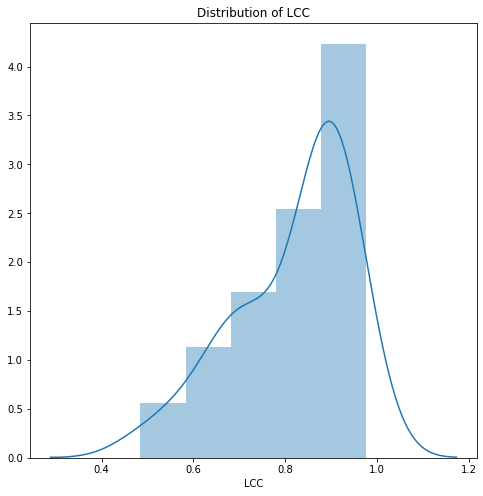

In [35]:
plt.figure(figsize=(8,8))
sb.distplot(LCC)
plt.xlabel('LCC')
plt.title('Distribution of LCC')
plt.show()

In [36]:
i = 0
for idx in range(len(RMSE)):
  if math.isnan(RMSE[idx]):
    RMSE[idx] = RMSE_[i]
    i += 1

sum(RMSE)/len(RMSE) 

0.1862728782266779

In [42]:
SROCC

[SpearmanrResult(correlation=0.7581908408230302, pvalue=6.561051130487222e-26),
 SpearmanrResult(correlation=0.6258587492991815, pvalue=2.810319471556787e-15),
 SpearmanrResult(correlation=0.8691664708884284, pvalue=4.880203004750271e-44),
 SpearmanrResult(correlation=0.8541864685649257, pvalue=7.327778083835478e-56),
 SpearmanrResult(correlation=0.9084948833392006, pvalue=3.1121913034602085e-60),
 SpearmanrResult(correlation=0.6561796248533871, pvalue=4.274094837674265e-18),
 SpearmanrResult(correlation=0.9254133915669523, pvalue=3.0145656689570256e-53),
 SpearmanrResult(correlation=0.629620363208027, pvalue=4.7682272405455315e-15),
 SpearmanrResult(correlation=0.46395746755122586, pvalue=9.445076879627866e-08),
 SpearmanrResult(correlation=0.8598074102803137, pvalue=1.8436616058736034e-44),
 SpearmanrResult(correlation=0.783907926649423, pvalue=5.106487586698194e-27),
 SpearmanrResult(correlation=0.9147064918933155, pvalue=4.126289956822655e-75),
 SpearmanrResult(correlation=0.823662

In [48]:
i = 0
SROCC_new = SROCC
for idx in range(len(SROCC)):
  if math.isnan(SROCC[idx][0]):
    SROCC[idx] = SROCC_[i][0]
    i += 1
  else:
    SROCC_new[idx] = SROCC[idx][0]

sum(SROCC_new)/len(SROCC_new)

0.7679576662873544

In [49]:
print('Best in SROCC: ', max(SROCC_new))
print('Worst in SROCC: ', min(SROCC))

Best in SROCC:  0.9546225341429876
Worst in SROCC:  0.3523731048649214


Test video number:  1
Train on 895 samples, validate on 895 samples
Epoch 1/200
 - 5s - loss: 0.0548 - val_loss: 0.0399
Epoch 2/200
 - 4s - loss: 0.0261 - val_loss: 0.0223
Epoch 3/200
 - 4s - loss: 0.0226 - val_loss: 0.0197
Epoch 4/200
 - 4s - loss: 0.0216 - val_loss: 0.0191
Epoch 5/200
 - 5s - loss: 0.0211 - val_loss: 0.0189
Epoch 6/200
 - 4s - loss: 0.0207 - val_loss: 0.0187
Epoch 7/200
 - 5s - loss: 0.0204 - val_loss: 0.0185
Epoch 8/200
 - 4s - loss: 0.0201 - val_loss: 0.0182
Epoch 9/200
 - 4s - loss: 0.0197 - val_loss: 0.0180
Epoch 10/200
 - 4s - loss: 0.0194 - val_loss: 0.0178
Epoch 11/200
 - 4s - loss: 0.0191 - val_loss: 0.0178
Epoch 12/200
 - 4s - loss: 0.0189 - val_loss: 0.0178
Epoch 13/200
 - 4s - loss: 0.0186 - val_loss: 0.0178
Epoch 14/200
 - 4s - loss: 0.0184 - val_loss: 0.0179
Epoch 15/200
 - 4s - loss: 0.0182 - val_loss: 0.0181
Epoch 16/200
 - 5s - loss: 0.0180 - val_loss: 0.0182
Epoch 17/200
 - 4s - loss: 0.0179 - val_loss: 0.0182
Epoch 18/200
 - 4s - loss: 0.0178 - val_

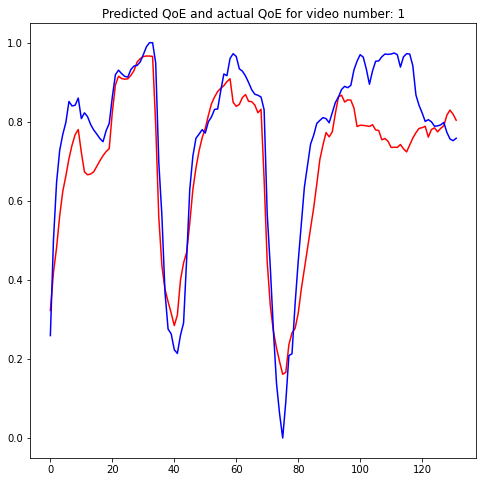

+++++++++++++++
Test video number:  2
Train on 918 samples, validate on 918 samples
Epoch 1/200
 - 5s - loss: 0.0612 - val_loss: 0.0441
Epoch 2/200
 - 5s - loss: 0.0252 - val_loss: 0.0283
Epoch 3/200
 - 5s - loss: 0.0223 - val_loss: 0.0234
Epoch 4/200
 - 5s - loss: 0.0213 - val_loss: 0.0215
Epoch 5/200
 - 5s - loss: 0.0206 - val_loss: 0.0205
Epoch 6/200
 - 5s - loss: 0.0200 - val_loss: 0.0198
Epoch 7/200
 - 5s - loss: 0.0195 - val_loss: 0.0192
Epoch 8/200
 - 5s - loss: 0.0191 - val_loss: 0.0186
Epoch 9/200
 - 5s - loss: 0.0187 - val_loss: 0.0181
Epoch 10/200
 - 5s - loss: 0.0184 - val_loss: 0.0176
Epoch 11/200
 - 5s - loss: 0.0181 - val_loss: 0.0172
Epoch 12/200
 - 4s - loss: 0.0178 - val_loss: 0.0169
Epoch 13/200
 - 5s - loss: 0.0176 - val_loss: 0.0167
Epoch 14/200
 - 5s - loss: 0.0174 - val_loss: 0.0165
Epoch 15/200
 - 5s - loss: 0.0171 - val_loss: 0.0163
Epoch 16/200
 - 5s - loss: 0.0169 - val_loss: 0.0162
Epoch 17/200
 - 5s - loss: 0.0168 - val_loss: 0.0161
Epoch 18/200
 - 5s - los

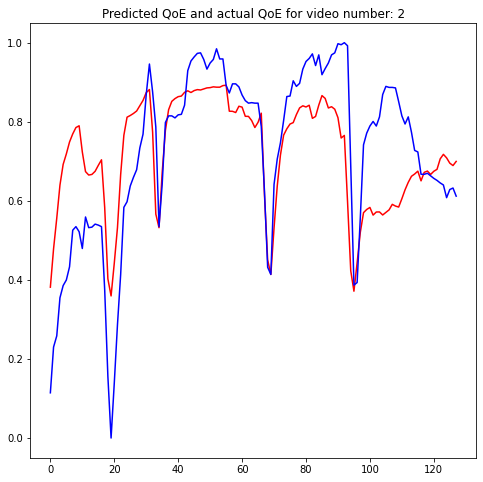

+++++++++++++++
Test video number:  3
Train on 898 samples, validate on 898 samples
Epoch 1/200
 - 5s - loss: 0.0534 - val_loss: 0.0277
Epoch 2/200
 - 5s - loss: 0.0248 - val_loss: 0.0218
Epoch 3/200
 - 4s - loss: 0.0226 - val_loss: 0.0199
Epoch 4/200
 - 5s - loss: 0.0216 - val_loss: 0.0194
Epoch 5/200
 - 4s - loss: 0.0211 - val_loss: 0.0191
Epoch 6/200
 - 5s - loss: 0.0207 - val_loss: 0.0188
Epoch 7/200
 - 4s - loss: 0.0204 - val_loss: 0.0184
Epoch 8/200
 - 5s - loss: 0.0201 - val_loss: 0.0181
Epoch 9/200
 - 4s - loss: 0.0198 - val_loss: 0.0177
Epoch 10/200
 - 5s - loss: 0.0196 - val_loss: 0.0174
Epoch 11/200
 - 5s - loss: 0.0193 - val_loss: 0.0172
Epoch 12/200
 - 4s - loss: 0.0192 - val_loss: 0.0171
Epoch 13/200
 - 5s - loss: 0.0190 - val_loss: 0.0169
Epoch 14/200
 - 5s - loss: 0.0188 - val_loss: 0.0168
Epoch 15/200
 - 5s - loss: 0.0186 - val_loss: 0.0167
Epoch 16/200
 - 5s - loss: 0.0185 - val_loss: 0.0166
Epoch 17/200
 - 4s - loss: 0.0183 - val_loss: 0.0166
Epoch 18/200
 - 5s - los

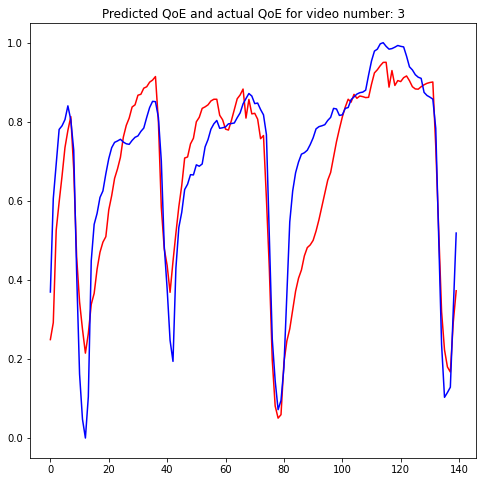

+++++++++++++++
Test video number:  4
Train on 853 samples, validate on 853 samples
Epoch 1/200
 - 5s - loss: 0.0592 - val_loss: 0.0366
Epoch 2/200
 - 4s - loss: 0.0284 - val_loss: 0.0282
Epoch 3/200
 - 4s - loss: 0.0255 - val_loss: 0.0251
Epoch 4/200
 - 4s - loss: 0.0242 - val_loss: 0.0232
Epoch 5/200
 - 4s - loss: 0.0232 - val_loss: 0.0218
Epoch 6/200
 - 4s - loss: 0.0224 - val_loss: 0.0210
Epoch 7/200
 - 4s - loss: 0.0218 - val_loss: 0.0204
Epoch 8/200
 - 4s - loss: 0.0212 - val_loss: 0.0199
Epoch 9/200
 - 4s - loss: 0.0207 - val_loss: 0.0195
Epoch 10/200
 - 4s - loss: 0.0202 - val_loss: 0.0191
Epoch 11/200
 - 4s - loss: 0.0198 - val_loss: 0.0187
Epoch 12/200
 - 4s - loss: 0.0195 - val_loss: 0.0184
Epoch 13/200
 - 4s - loss: 0.0193 - val_loss: 0.0183
Epoch 14/200
 - 4s - loss: 0.0190 - val_loss: 0.0181
Epoch 15/200
 - 4s - loss: 0.0189 - val_loss: 0.0180
Epoch 16/200
 - 4s - loss: 0.0187 - val_loss: 0.0179
Epoch 17/200
 - 4s - loss: 0.0185 - val_loss: 0.0177
Epoch 18/200
 - 4s - los

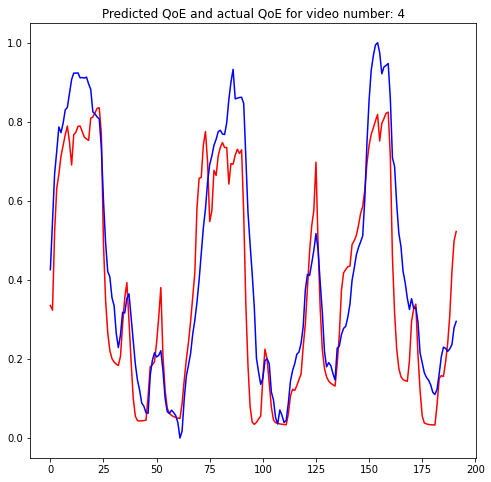

+++++++++++++++
Test video number:  5
Train on 871 samples, validate on 871 samples
Epoch 1/200
 - 5s - loss: 0.0590 - val_loss: 0.0274
Epoch 2/200
 - 4s - loss: 0.0292 - val_loss: 0.0240
Epoch 3/200
 - 4s - loss: 0.0264 - val_loss: 0.0233
Epoch 4/200
 - 4s - loss: 0.0252 - val_loss: 0.0230
Epoch 5/200
 - 4s - loss: 0.0246 - val_loss: 0.0229
Epoch 6/200
 - 4s - loss: 0.0241 - val_loss: 0.0231
Epoch 7/200
 - 4s - loss: 0.0238 - val_loss: 0.0235
Epoch 8/200
 - 4s - loss: 0.0236 - val_loss: 0.0238
Epoch 9/200
 - 4s - loss: 0.0233 - val_loss: 0.0240
Epoch 10/200
 - 4s - loss: 0.0229 - val_loss: 0.0240
Epoch 11/200
 - 4s - loss: 0.0225 - val_loss: 0.0236
Epoch 12/200
 - 4s - loss: 0.0221 - val_loss: 0.0231
Epoch 13/200
 - 4s - loss: 0.0217 - val_loss: 0.0228
Epoch 14/200
 - 4s - loss: 0.0214 - val_loss: 0.0224
Epoch 15/200
 - 4s - loss: 0.0212 - val_loss: 0.0222
Epoch 16/200
 - 4s - loss: 0.0210 - val_loss: 0.0220
Epoch 17/200
 - 4s - loss: 0.0208 - val_loss: 0.0218
Epoch 18/200
 - 4s - los

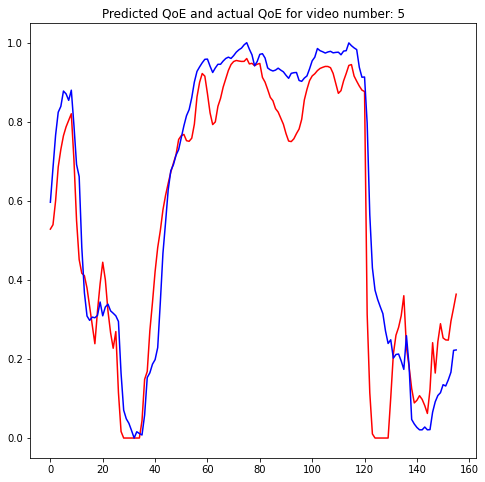

+++++++++++++++
Test video number:  6
Train on 893 samples, validate on 893 samples
Epoch 1/200
 - 5s - loss: 0.0542 - val_loss: 0.0262
Epoch 2/200
 - 5s - loss: 0.0237 - val_loss: 0.0191
Epoch 3/200
 - 4s - loss: 0.0216 - val_loss: 0.0183
Epoch 4/200
 - 4s - loss: 0.0206 - val_loss: 0.0179
Epoch 5/200
 - 5s - loss: 0.0198 - val_loss: 0.0174
Epoch 6/200
 - 4s - loss: 0.0191 - val_loss: 0.0169
Epoch 7/200
 - 5s - loss: 0.0185 - val_loss: 0.0164
Epoch 8/200
 - 4s - loss: 0.0180 - val_loss: 0.0160
Epoch 9/200
 - 4s - loss: 0.0176 - val_loss: 0.0157
Epoch 10/200
 - 5s - loss: 0.0173 - val_loss: 0.0155
Epoch 11/200
 - 5s - loss: 0.0170 - val_loss: 0.0153
Epoch 12/200
 - 4s - loss: 0.0168 - val_loss: 0.0152
Epoch 13/200
 - 5s - loss: 0.0166 - val_loss: 0.0151
Epoch 14/200
 - 5s - loss: 0.0165 - val_loss: 0.0151
Epoch 15/200
 - 4s - loss: 0.0164 - val_loss: 0.0151
Epoch 16/200
 - 5s - loss: 0.0164 - val_loss: 0.0151
Epoch 17/200
 - 5s - loss: 0.0164 - val_loss: 0.0151
Epoch 18/200
 - 5s - los

In [0]:
LCC_1 = []
SROCC_1 = []
RMSE_1 = []

for test_no in range(1, num_of_videos + 1):

  print('Test video number: ', test_no)
  attributes = []
  target = []
  attributes1 = []
  target1 = []
  test_attributes = []
  test_actual_scores = []

  training_videos_lst = training_videos_indices[test_no - 1]
  validation_videos_lst = validation_videos_indices[test_no - 1]

  #Training data preparation
  for train_idx in range(0,num_of_training):
      
      attributes, target = train_val_processing(training_videos_lst, train_idx, attributes, target)

  training_attrs = attributes[:int(len(attributes)//timesteps * timesteps),:]
  training_label = target[:int(len(target)//timesteps * timesteps), :]

  training_attrs_ts = training_attrs.reshape(-1, timesteps, training_attrs.shape[1])
  training_label_ts = training_label.reshape(-1, timesteps, training_label.shape[1])

  #Validation data preparation
  for val_idx in range(0,num_of_validation):

      attributes1, target1 = train_val_processing(validation_videos_lst, val_idx, attributes1, target1)

  validation_attrs = attributes1[:int(len(attributes1)//timesteps * timesteps),:]
  validation_label = target1[:int(len(target1)//timesteps * timesteps),:]

  validation_attrs_ts = training_attrs.reshape(-1, timesteps, validation_attrs.shape[1])
  validation_label_ts = training_label.reshape(-1, timesteps, validation_label.shape[1])

  #Testing data preparation
  test_video = loadmat(path + '/QoE_matfiles' + '/video_' + str(test_no) + '.mat')
  NIQE = np.array(test_video['NIQE_ext'])
  number_rebuff = np.array(test_video['Nrebuffers'])
  time_elapsed = np.array(test_video['TSL'])
  scores = np.array(test_video['score_continuous'])

  data_for_scaling = np.dstack((NIQE, scores))
  data_for_scaling = data_for_scaling.reshape(data_for_scaling.shape[1], data_for_scaling.shape[2])

  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data_for_scaling)
  scaled_data = scaler.transform(data_for_scaling)

  NIQE_norm = scaled_data[:,0]
  scores_norm = scaled_data[:,1]

  video_features = np.dstack((NIQE_norm, number_rebuff, time_elapsed))
  video_features = video_features.reshape(video_features.shape[1], video_features.shape[2])

  QoE_actual = scores_norm.reshape(scores_norm.shape[0], 1)
  test_attributes = video_features.reshape(-1, 1, video_features.shape[1])

  train_LSTM_model_2(training_attrs_ts, training_label_ts, validation_attrs_ts, validation_label_ts, 200, num_of_layers, num_of_units, batch_size, timesteps, num_of_features, loss, opt, test_no)
  model = keras.models.load_model(path + '/model' + str(test_no) + '_checkpoint.h5')
  test_attributes = test_attributes[:int(len(test_attributes)//timesteps*timesteps),:]
  test_attributes = test_attributes.reshape(-1, timesteps, test_attributes.shape[2])
  pred = model.predict(test_attributes,batch_size=1)
  pred = np.reshape(pred, (-1,1))
  pred = pred.reshape(-1,pred.shape[0])[0]
  QoE_actual = QoE_actual[:int(len(QoE_actual)//timesteps*timesteps),:]
  QoE_actual = QoE_actual.reshape(-1,QoE_actual.shape[0])[0]
  
  LCC_1.append(pearsonr(pred, QoE_actual)[0])
  SROCC_1.append(spearmanr(pred, QoE_actual))
  RMSE_1.append(sqrt(mean_squared_error(pred, QoE_actual)))

  plt.figure(figsize=(8,8))
  plt.plot(pred, 'r', label = 'Predicted QoE')
  plt.plot(QoE_actual, 'b', label = 'Actual QoE')
  plt.title('Predicted QoE and actual QoE for video number: %d'%(test_no))
  plt.savefig(path + '/Pictures/fig_' + str(test_no) + '.png')
  if test_no <= 5:
    plt.show()
  else:
    plt.close()

  print('+' *15)

In [0]:
retrain_model = []
for idx in range(0,len(LCC_1)):
  if math.isnan(LCC_1[idx]) == True:
    retrain_model.append(idx + 1) 

In [0]:
LCC_2 = []
SROCC_2 = []
RMSE_2 = []

for test_no in range(1, num_of_videos + 1):

  if test_no in retrain_model:
    print('Test video number: ', test_no)
    attributes = []
    target = []
    attributes1 = []
    target1 = []
    test_attributes = []
    test_actual_scores = []

    training_videos_lst = training_videos_indices[test_no - 1]
    validation_videos_lst = validation_videos_indices[test_no - 1]

    #Training data preparation
    for train_idx in range(0,num_of_training):
        
        attributes, target = train_val_processing(training_videos_lst, train_idx, attributes, target)

    training_attrs = attributes[:int(len(attributes)//timesteps * timesteps),:]
    training_label = target[:int(len(target)//timesteps * timesteps), :]

    training_attrs_ts = training_attrs.reshape(-1, timesteps, training_attrs.shape[1])
    training_label_ts = training_label.reshape(-1, timesteps, training_label.shape[1])

    #Validation data preparation
    for val_idx in range(0,num_of_validation):

        attributes1, target1 = train_val_processing(validation_videos_lst, val_idx, attributes1, target1)

    validation_attrs = attributes1[:int(len(attributes1)//timesteps * timesteps),:]
    validation_label = target1[:int(len(target1)//timesteps * timesteps),:]

    validation_attrs_ts = training_attrs.reshape(-1, timesteps, validation_attrs.shape[1])
    validation_label_ts = training_label.reshape(-1, timesteps, validation_label.shape[1])

    #Testing data preparation
    test_video = loadmat(path + '/QoE_matfiles' + '/video_' + str(test_no) + '.mat')
    NIQE = np.array(test_video['NIQE_ext'])
    number_rebuff = np.array(test_video['Nrebuffers'])
    time_elapsed = np.array(test_video['TSL'])
    scores = np.array(test_video['score_continuous'])

    data_for_scaling = np.dstack((NIQE, scores))
    data_for_scaling = data_for_scaling.reshape(data_for_scaling.shape[1], data_for_scaling.shape[2])

    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(data_for_scaling)
    scaled_data = scaler.transform(data_for_scaling)

    NIQE_norm = scaled_data[:,0]
    scores_norm = scaled_data[:,1]

    video_features = np.dstack((NIQE_norm, number_rebuff, time_elapsed))
    video_features = video_features.reshape(video_features.shape[1], video_features.shape[2])

    QoE_actual = scores_norm.reshape(scores_norm.shape[0], 1)
    test_attributes = video_features.reshape(-1, 1, video_features.shape[1])

    train_LSTM_model_2(training_attrs_ts, training_label_ts, validation_attrs_ts, validation_label_ts, 200, num_of_layers, num_of_units, batch_size, timesteps, num_of_features, loss, opt, test_no)
    model = keras.models.load_model(path + '/model' + str(test_no) + '_checkpoint.h5')
    test_attributes = test_attributes[:int(len(test_attributes)//timesteps*timesteps),:]
    test_attributes = test_attributes.reshape(-1, timesteps, test_attributes.shape[2])
    pred = model.predict(test_attributes,batch_size=1)
    pred = np.reshape(pred, (-1,1))
    pred = pred.reshape(-1,pred.shape[0])[0]
    QoE_actual = QoE_actual[:int(len(QoE_actual)//timesteps*timesteps),:]
    QoE_actual = QoE_actual.reshape(-1,QoE_actual.shape[0])[0]
    
    LCC_2.append(pearsonr(pred, QoE_actual)[0])
    SROCC_2.append(spearmanr(pred, QoE_actual))
    RMSE_2.append(sqrt(mean_squared_error(pred, QoE_actual)))

    plt.figure(figsize=(8,8))
    plt.plot(pred, 'r', label = 'Predicted QoE')
    plt.plot(QoE_actual, 'b', label = 'Actual QoE')
    plt.title('Predicted QoE and actual QoE for video number: %d'%(test_no))
    plt.savefig(path + '/Pictures/fig_' + str(test_no) + '.png')
    if test_no <= 5:
      plt.show()
    else:
      plt.close()

    print('+' *15)

Test video number:  17
Train on 938 samples, validate on 938 samples
Epoch 1/200
 - 5s - loss: 0.0527 - val_loss: 0.0301
Epoch 2/200
 - 5s - loss: 0.0248 - val_loss: 0.0244
Epoch 3/200
 - 4s - loss: 0.0227 - val_loss: 0.0217
Epoch 4/200
 - 4s - loss: 0.0214 - val_loss: 0.0200
Epoch 5/200
 - 5s - loss: 0.0206 - val_loss: 0.0192
Epoch 6/200
 - 5s - loss: 0.0201 - val_loss: 0.0189
Epoch 7/200
 - 4s - loss: 0.0198 - val_loss: 0.0185
Epoch 8/200
 - 4s - loss: 0.0196 - val_loss: 0.0182
Epoch 9/200
 - 4s - loss: 0.0192 - val_loss: 0.0179
Epoch 10/200
 - 4s - loss: 0.0192 - val_loss: 0.0176
Epoch 11/200
 - 5s - loss: 0.0190 - val_loss: 0.0175
Epoch 12/200
 - 5s - loss: 0.0187 - val_loss: 0.0175
Epoch 13/200
 - 5s - loss: 0.0185 - val_loss: 0.0174
Epoch 14/200
 - 4s - loss: 0.0183 - val_loss: 0.0174
Epoch 15/200
 - 4s - loss: 0.0182 - val_loss: 0.0175
Epoch 16/200
 - 4s - loss: 0.0180 - val_loss: 0.0177
Epoch 17/200
 - 4s - loss: 0.0179 - val_loss: 0.0178
Epoch 18/200
 - 5s - loss: 0.0179 - val

In [0]:
LCC_1[16] = LCC_2[0]
LCC_1[26] = LCC_2[1]
sum(LCC_1)/len(LCC_1)

0.8359335694849738

In [0]:
test_attributes = test_attributes[:132,:]
test_attributes = test_attributes.reshape(-1, timesteps, test_attributes.shape[2])
pred = model.predict(test_attributes,batch_size=1)
pred = np.reshape(pred, (-1,1))
pred = pred.reshape(-1,132)[0]
QoE_actual = QoE_actual[:132,:].reshape(-1,132)[0]
pearsonr(pred, QoE_actual)

(0.9071518544213026, 1.0376505873372256e-50)

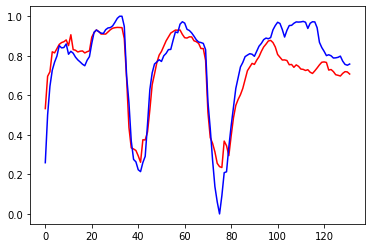

In [0]:
plt.plot(pred,'r')
plt.plot(QoE_actual,'b')
plt.show()

In [0]:
pred.reshape(-1,132).shape

(1, 132)

In [0]:
QoE_actual[:132,:].reshape(-1,1)

array([[0.25913043],
       [0.50086957],
       [0.64608696],
       [0.72695652],
       [0.76782609],
       [0.79826087],
       [0.85130435],
       [0.84      ],
       [0.84173913],
       [0.86      ],
       [0.80782609],
       [0.8226087 ],
       [0.81304348],
       [0.79304348],
       [0.77913043],
       [0.76869565],
       [0.7573913 ],
       [0.74956522],
       [0.7773913 ],
       [0.79565217],
       [0.8626087 ],
       [0.91913043],
       [0.93043478],
       [0.92173913],
       [0.91478261],
       [0.91304348],
       [0.93217391],
       [0.94086957],
       [0.9426087 ],
       [0.95130435],
       [0.96956522],
       [0.98956522],
       [1.        ],
       [1.        ],
       [0.94869565],
       [0.6973913 ],
       [0.5626087 ],
       [0.36869565],
       [0.27565217],
       [0.26347826],
       [0.22347826],
       [0.21391304],
       [0.26      ],
       [0.29130435],
       [0.45391304],
       [0.62869565],
       [0.71304348],
       [0.758

In [0]:
a = np.array([1,2,3,4,5])
b = np.array([1,2,3,3,5])
pearsonr(a,b)

(0.9594032236002469, 0.009759076704905544)

In [0]:
a = test_attributes.reshape(134,3)
a = a[:132,:]

In [0]:
a.reshape(-1,4,3)

array([[[0.36993617, 0.        , 0.00746269],
        [0.38589517, 0.        , 0.01492537],
        [0.41879894, 0.        , 0.02238806],
        [0.25660332, 0.        , 0.02985075]],

       [[0.26819128, 0.        , 0.03731343],
        [0.31863089, 0.        , 0.04477612],
        [0.26206607, 0.        , 0.05223881],
        [0.25489879, 0.        , 0.05970149]],

       [[0.25621362, 0.        , 0.06716418],
        [0.29990435, 0.        , 0.07462687],
        [0.67114668, 0.        , 0.08208955],
        [0.87767655, 0.        , 0.08955224]],

       [[0.86010384, 0.        , 0.09701493],
        [0.84556479, 0.        , 0.10447761],
        [0.81734334, 0.        , 0.1119403 ],
        [0.74917296, 0.        , 0.11940299]],

       [[0.70464879, 0.        , 0.12686567],
        [0.67408583, 0.        , 0.13432836],
        [0.65640613, 0.        , 0.14179104],
        [0.65369532, 0.        , 0.14925373]],

       [[0.14893037, 0.        , 0.15671642],
        [0.        , 0. 